# 台灣犯罪圖解  資料日期: 104/01~107/03

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] 
%matplotlib inline

### 讀入資料

In [2]:
crime = pd.read_csv('crime.csv')

### 資料筆數

In [3]:
crime.shape

(177801, 3)

### 資料範例

In [4]:
crime.head()

,案類,發生日期,發生地點
0,住宅竊盜,1040101,台北市中山區
1,住宅竊盜,1040101,新北市永和區
2,住宅竊盜,1040101,台東縣台東市
3,住宅竊盜,1040101,台北市文山區
4,住宅竊盜,1040101,新北市三重區


### 將發生日期拆為   年  月  日

In [5]:
#crime['發生日期'] = crime['發生日期'].astype(str)
crime['year'] = (crime['發生日期']//10000) + 1911 #西元轉換
crime['month'] = ((crime['發生日期'] + 19110000) - (10000 * crime['year']))//100
crime['day'] = crime['發生日期'] + 19110000 - (10000 * crime['year']) - (100 * crime['month'])

### 發現日期有 0 日  的錯誤資料

In [6]:
crime['day'].value_counts().sort_index().head()

0       9
1    7502
2    6217
3    6226
4    6415
Name: day, dtype: int64

### 刪除錯誤的資料

In [7]:
crime = crime.query('day != 0')

In [8]:
crime.shape

(177792, 6)

### 將日期設為 DatetimeIndex

In [9]:
crime.index = pd.to_datetime(10000 * crime.year + 100 * crime.month + crime.day, format='%Y%m%d')
crime = crime[['案類', '發生地點']]
crime.index.name = 'date'
crime.head()

,案類,發生地點
date,,
2015-01-01,住宅竊盜,台北市中山區
2015-01-01,住宅竊盜,新北市永和區
2015-01-01,住宅竊盜,台東縣台東市
2015-01-01,住宅竊盜,台北市文山區
2015-01-01,住宅竊盜,新北市三重區


### 將發生地點拆為 縣市(city) 和 鄉鎮區(country)

In [10]:
crime['city'] = crime['發生地點'].str[0:3]
crime['country'] = crime['發生地點'].str[3:]

### 檢查空值

In [11]:
display(crime['country'].isnull().any())
display(crime['country'].isnull().sum())

True

1

### 刪去空值

In [12]:
crime = crime[crime['country'].notnull()]
crime.shape

(177791, 4)

### 發現縣市出現了奇怪的'新竹鹿?', '台灣海?'

##### 刪除 新竹鹿, 外國, 台灣海 

In [13]:
crime['city'].value_counts().tail()

澎湖縣    230
連江縣     34
外國       5
台灣海      1
新竹鹿      1
Name: city, dtype: int64

In [14]:
crime = crime[crime['city'] != '新竹鹿']
crime = crime[crime['city'] != '台灣海']
crime = crime[crime['city'] != '外國']
crime.shape

(177784, 4)

In [15]:
crime.head()

,案類,發生地點,city,country
date,,,,
2015-01-01,住宅竊盜,台北市中山區,台北市,中山區
2015-01-01,住宅竊盜,新北市永和區,新北市,永和區
2015-01-01,住宅竊盜,台東縣台東市,台東縣,台東市
2015-01-01,住宅竊盜,台北市文山區,台北市,文山區
2015-01-01,住宅竊盜,新北市三重區,新北市,三重區


### 將 縣市 案類  加入階層Index 並計數

In [16]:
crime.columns = ['kind', '發生地點', 'city', 'country']
crime = crime[['kind', 'city', 'country']]
crime['num'] = 1

In [17]:
crime.head()

,kind,city,country,num
date,,,,
2015-01-01,住宅竊盜,台北市,中山區,1
2015-01-01,住宅竊盜,新北市,永和區,1
2015-01-01,住宅竊盜,台東縣,台東市,1
2015-01-01,住宅竊盜,台北市,文山區,1
2015-01-01,住宅竊盜,新北市,三重區,1


### 資料整理完成 開始討論

## 案類比例

In [18]:
#ckind = crcount.pivot_table('num', index='kind', aggfunc='sum')
ckind = crime.groupby('kind').sum()
ckind = ckind/ckind.values.sum()*100
ckind.columns = ['percentage(%)']
ckind.sort_values(by='percentage(%)')

,percentage(%)
kind,
搶奪,0.511857
強盜,0.522544
強制性交,0.598479
住宅竊盜,4.796832
汽車竊盜,6.914008
機車竊盜,22.999820
毒品,63.656460


#### 毒品最大宗 約占了63.6%

#### 搶奪 強盜 強制性交 強迫他人的犯罪約在0.5 ~ 0.6%

#### 偷竊以機車竊盜最為嚴重 23%

## 案發地點討論

### 這裡要抓入台灣縣市人口數資料

In [19]:
place = crime.groupby('city').sum().reset_index()
pop = pd.read_csv('TW_pop.csv').sort_values(by='縣市')
pop.iloc[12:16,0] = '台' + pop.iloc[12:16,0].str[1:]
pop.columns = ['city', 'pop']
place = pd.merge(place, pop).set_index('city')
place = place.eval('time = 10000 * num / pop ').iloc[:,[2]]
place = place.sort_values(by='time')
place.columns=['time/10K People']
place

,time/10K People
city,
金門縣,18.551391
澎湖縣,22.099872
連江縣,26.397516
嘉義縣,43.213572
彰化縣,49.989941
台中市,55.660604
台東縣,57.757129
台南市,63.253967
台北市,63.355840


## 細部案類討論

In [20]:
pcek = crime.pivot_table('num', index='city', columns='kind', aggfunc='sum', margins=True, fill_value=0).reset_index()
pcek = pd.merge(pcek, pop).set_index('city')
pcek = (10000 * pcek.T / pcek['pop']).T
pcek = pcek.iloc[:,0:8]
pcek

,住宅竊盜,強制性交,強盜,搶奪,機車竊盜,毒品,汽車竊盜,All
city,,,,,,,,
南投縣,7.125023,0.918070,0.638658,0.379203,18.022118,48.198686,6.765778,82.047536
台中市,1.628951,0.315744,0.261924,0.287040,13.957310,35.869210,3.340426,55.660604
台北市,4.964116,0.674553,0.290691,0.327960,8.515770,47.501972,1.080776,63.355840
台南市,5.905046,0.811016,0.530076,0.455865,16.024197,33.855953,5.671813,63.253967
台東縣,2.004191,0.045550,0.136649,0.091100,15.623577,38.762868,1.093195,57.757129
嘉義市,2.227188,1.670391,0.371198,0.185599,11.173060,58.612165,7.683799,81.923400
嘉義縣,1.506313,0.899875,0.234750,0.215188,6.436064,28.698194,5.223189,43.213572
基隆市,6.353343,1.426810,0.942233,0.565340,17.713981,107.683776,2.207517,136.893000
宜蘭縣,5.891281,0.766524,0.569417,0.197106,12.089171,49.692624,6.175989,75.382112


## 案類分類排名:
#### 外島(澎湖 金門 馬祖)汽機車失竊特別低  但在住宅竊盜不輸本島
#### 汽機車竊盜罪嚴重在桃園新竹一帶
#### 基隆市毒品格外嚴重

In [21]:
for n in range(7):
    print(pcek.columns[n])
    display(pd.DataFrame((pcek.iloc[:,n]).sort_values(ascending=False)))
    print('')

住宅竊盜


,住宅竊盜
city,
南投縣,7.125023
澎湖縣,6.437789
基隆市,6.353343
雲林縣,6.214032
花蓮縣,5.983532
台南市,5.905046
宜蘭縣,5.891281
苗栗縣,5.453163
連江縣,5.434783



強制性交


,強制性交
city,
嘉義市,1.670391
基隆市,1.426810
金門縣,1.309510
澎湖縣,1.153037
南投縣,0.918070
嘉義縣,0.899875
花蓮縣,0.850451
台南市,0.811016
宜蘭縣,0.766524



強盜


,強盜
city,
基隆市,0.942233
南投縣,0.638658
雲林縣,0.579397
宜蘭縣,0.569417
苗栗縣,0.559762
台南市,0.530076
新竹縣,0.525202
花蓮縣,0.516345
新北市,0.436452



搶奪


,搶奪
city,
高雄市,0.810253
連江縣,0.776398
基隆市,0.565340
台南市,0.455865
彰化縣,0.397674
新北市,0.393811
新竹市,0.385372
南投縣,0.379203
屏東縣,0.373521



機車竊盜


,機車竊盜
city,
桃園市,36.283996
新竹市,32.235249
新竹縣,23.778952
高雄市,22.380976
南投縣,18.022118
新北市,17.856923
基隆市,17.713981
台南市,16.024197
台東縣,15.623577



毒品


,毒品
city,
基隆市,107.683776
桃園市,73.130145
花蓮縣,62.720776
新北市,61.931091
屏東縣,59.618839
嘉義市,58.612165
宜蘭縣,49.692624
南投縣,48.198686
台北市,47.501972



汽車竊盜


,汽車竊盜
city,
新竹縣,17.494644
桃園市,11.238487
苗栗縣,8.883961
嘉義市,7.683799
屏東縣,7.133054
南投縣,6.765778
高雄市,6.716093
新竹市,6.528658
宜蘭縣,6.175989


## 犯罪的周末?
#### 星期幾與犯罪數的關係

,time
dayofweek,
1,26202
2,27645
3,27772
4,26755
5,24817
6,22334
7,22259


Text(0.5, 0, 'dayofweek')

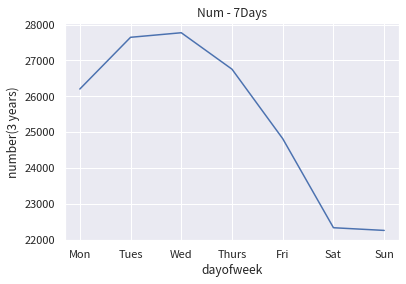

In [22]:
cweek = crime.groupby(crime.index.dayofweek).sum()
cweek.index = [1,2,3,4,5,6,7]
cweek.index.name = 'dayofweek'
cweek.columns = ['time']
display(cweek)
plt.plot(cweek)
plt.title('Num - 7Days')
plt.gca().set_xticklabels(['', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('number(3 years)')
plt.xlabel('dayofweek')

In [23]:
print('周末與平日的案件比例 : %.03f'%(cweek.values[5:].mean()/cweek.values[0:5].mean()))

周末與平日的案件比例 : 0.837



### 周末案件數約平日的80％  周休二日還沒確切落實在罪犯和警察身上
### 接著細部探究犯案種類和星期幾的關係

In [24]:
from matplotlib.font_manager import findfont, FontProperties  
findfont(FontProperties(family=FontProperties().get_family())) 

'/home/sppool/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/TaipeiSansTCBeta-Regular.ttf'

kind,住宅竊盜,強制性交,強盜,搶奪,機車竊盜,毒品,汽車竊盜
dayofweek,,,,,,,
1,15.361163,14.191729,13.455328,15.054945,15.517241,14.280160,16.051090
2,14.645872,14.003759,14.208827,17.032967,14.135485,16.200263,15.017898
3,13.391182,13.721805,14.747040,14.395604,13.949621,16.539573,14.594858
4,14.294090,10.620301,16.038751,13.406593,13.986305,15.639166,14.106736
5,14.997655,14.473684,14.854682,13.626374,14.287112,13.705808,14.391474
6,14.000938,17.575188,12.486545,13.406593,14.057227,11.880252,12.382037
7,13.309099,15.413534,14.208827,13.076923,14.067009,11.754778,13.455906


,weekend/weekday(%)
kind,
毒品,77.375236
汽車竊盜,87.099605
搶奪,90.059791
強盜,91.042584
住宅竊盜,93.926440
機車竊盜,97.822389
強制性交,123.071529


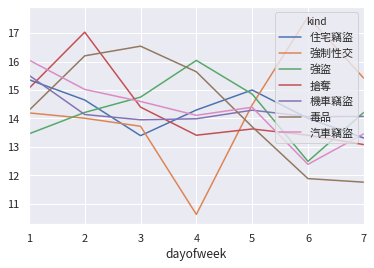

In [25]:
ckweek = crime.pivot_table('num', index=crime.index.dayofweek, columns='kind', aggfunc='sum')
ckweek.index = [1,2,3,4,5,6,7]
ckweek.index.name = 'dayofweek'
ckweek = ckweek/ckweek.sum()*100
display(ckweek)
ckweek.plot()

ckweek = pd.DataFrame((100 * ckweek[ckweek.index>5].mean()/ckweek[ckweek.index<6].mean()).sort_values())
ckweek.columns = ['weekend/weekday(%)']
ckweek

#### 強制性交在假日有明顯提高 周末要格外提防
#### 毒品在假日比較少  果然寂寞的時候才要吸毒
#### 機車竊盜假日平日並無不同

## 犯罪會跟日期365天有關嗎?
#### 看圖似乎有四季變化 圖形震盪就是顯示平日和假日一周變化

num
year month day city kind     
2015 1     1   南投縣  機車竊盜    1
               台中市  機車竊盜    5
                    毒品      7
                    汽車竊盜    2
               台北市  住宅竊盜    3
                    強制性交    1
                    機車竊盜    2
                    毒品     10

<function matplotlib.pyplot.legend(*args, **kwargs)>

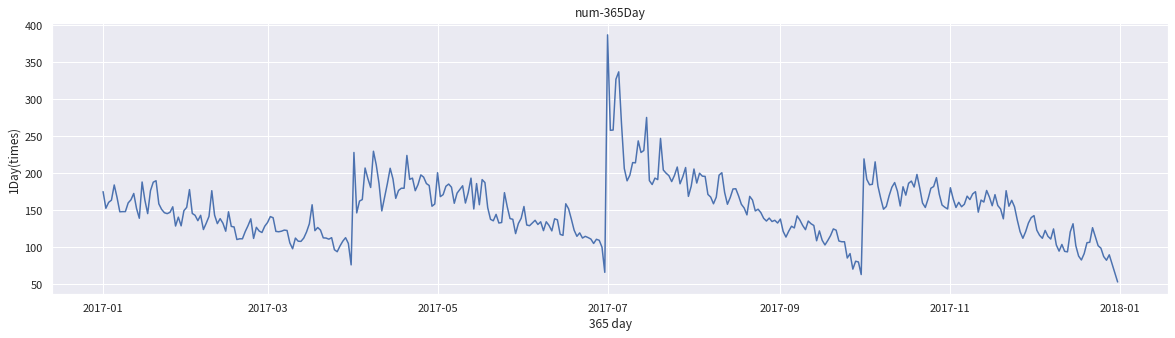

In [26]:
crcount = crime.groupby([crime.index.year, crime.index.month, crime.index.day, 'city', 'kind']).sum()
crcount.index.names = ['year', 'month', 'day', 'city', 'kind']
display(crcount.head(8))
cday = crcount.groupby(['year', 'month', 'day']).sum()
cday = cday.groupby(['month', 'day']).mean()

cday = cday.loc[(1, 1):(2, 28)].append(cday.loc[(3, 1):(12, 31)]) #除去(2/29)資料
cday.index = [pd.datetime(2017, month, day) for (month, day) in cday.index]
fig = plt.figure(figsize=(20, 5))
plt.plot(cday)
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.xlabel('365 day')
plt.legend

### 畫上2周均線 讓線圖更柔化  並將y軸歸零
#### 並透過高斯窗口 Cosine window 讓圖形看起來平滑

<function matplotlib.pyplot.legend(*args, **kwargs)>

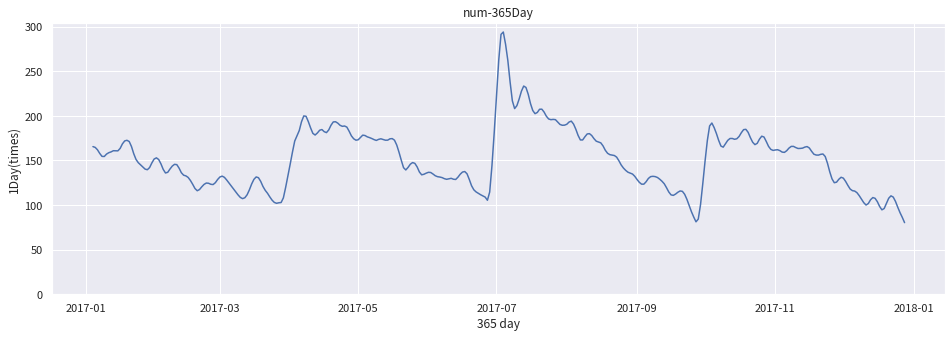

In [27]:
rolling = cday.rolling(7, center=True, win_type='cosine')
data = rolling.mean()

fig = plt.figure(figsize=(16, 5))
plt.plot(data)
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.ylim(0,)
plt.xlabel('365 day')
plt.legend

### 住宅竊盜和毒品有明顯四季變化
#### 每一季3個月循環 並緩慢下降
#### 毒品在七月初達到最高峰(暑假開始的原因??)

住宅竊盜


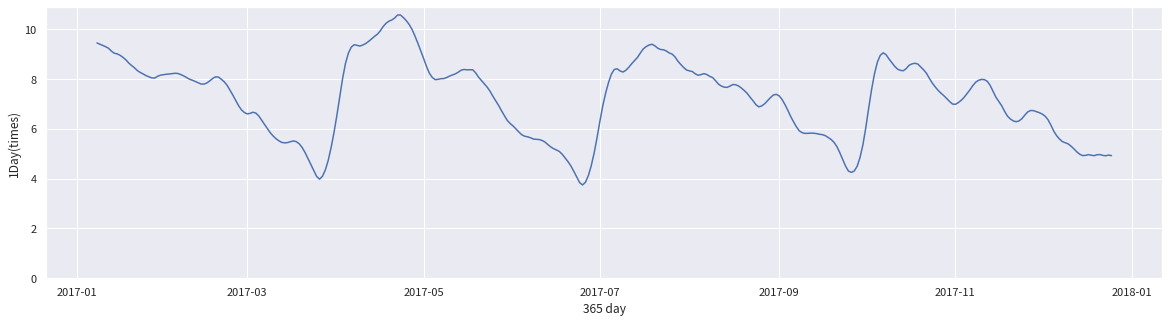

強制性交


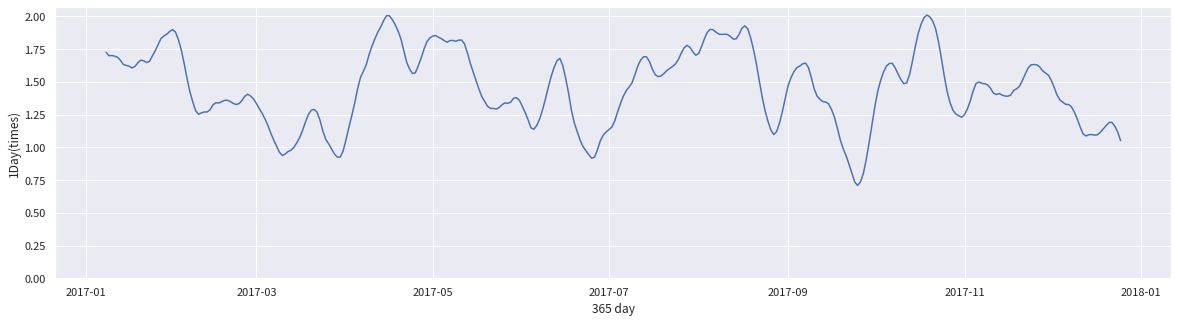

強盜


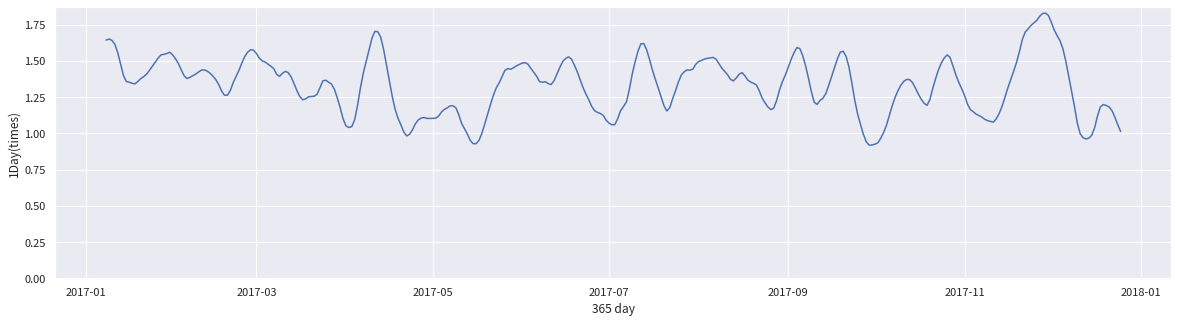

搶奪


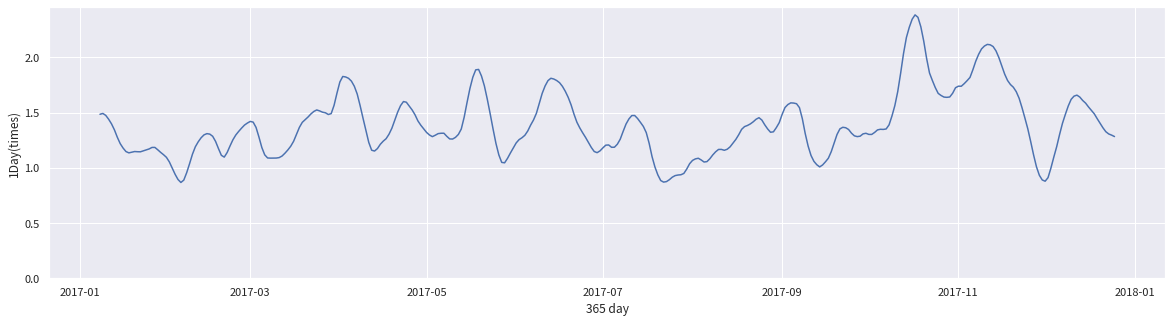

機車竊盜


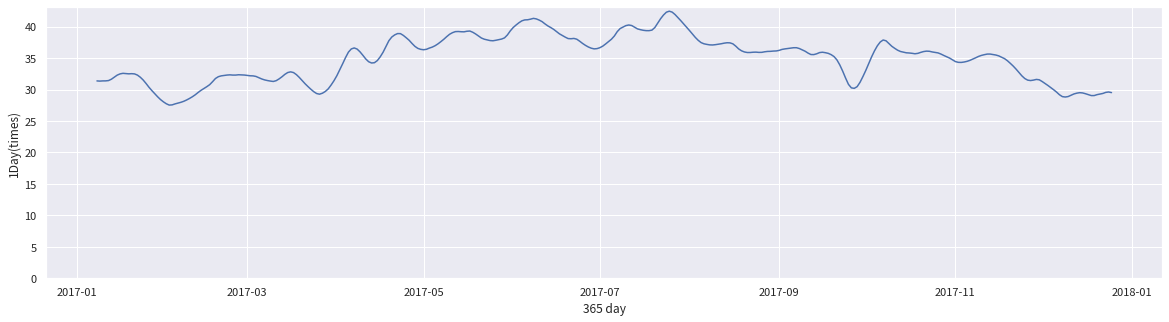

毒品


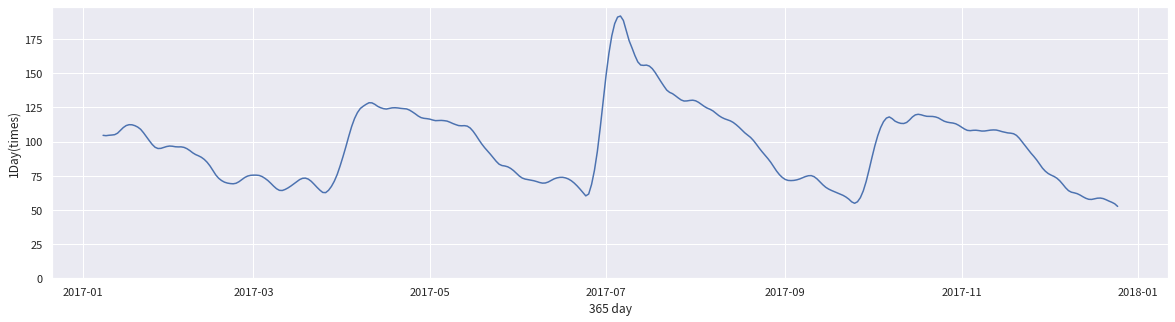

汽車竊盜


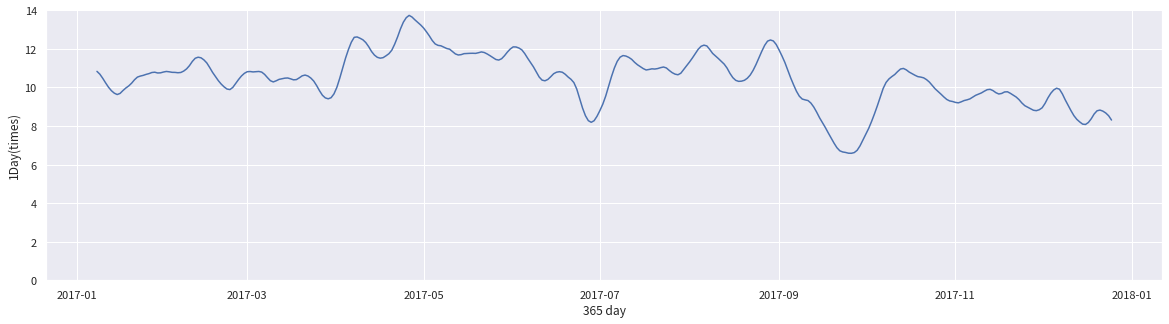

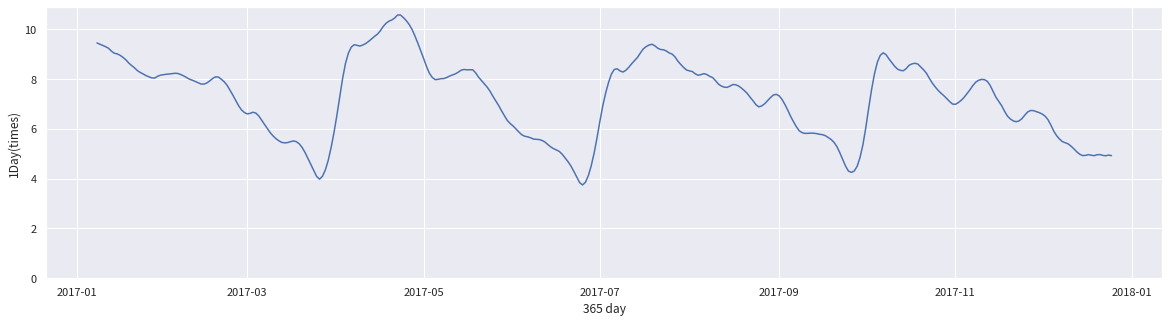

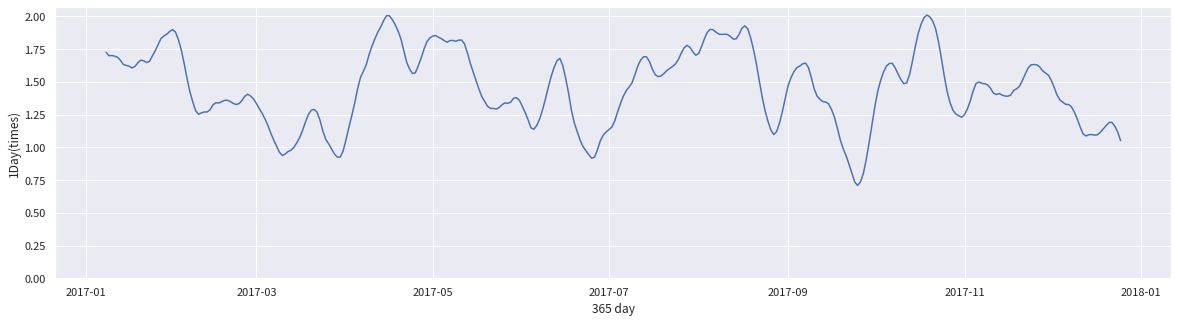

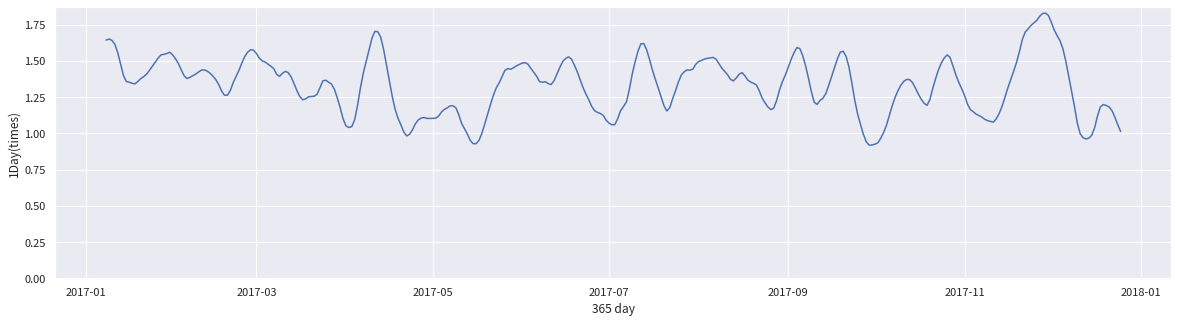

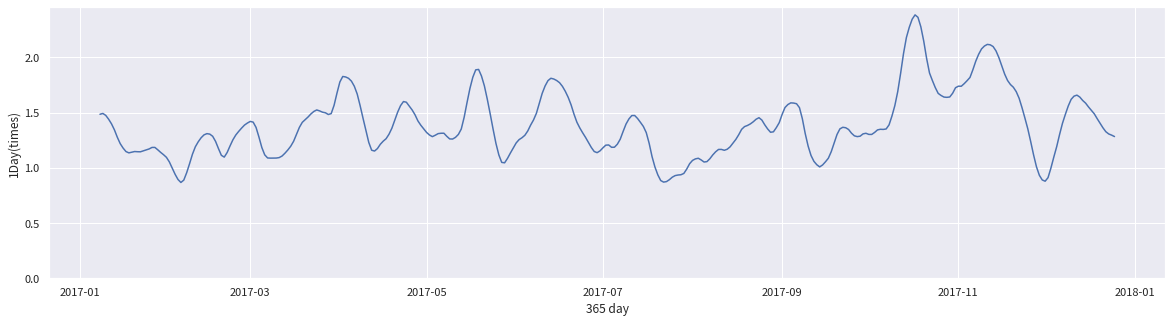

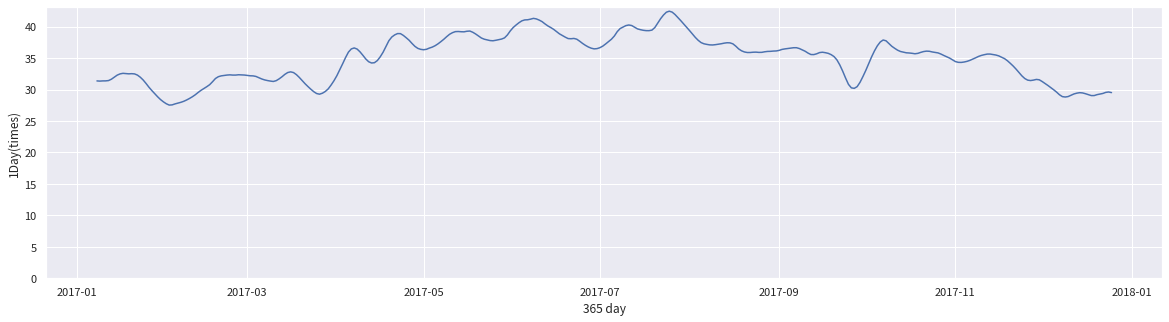

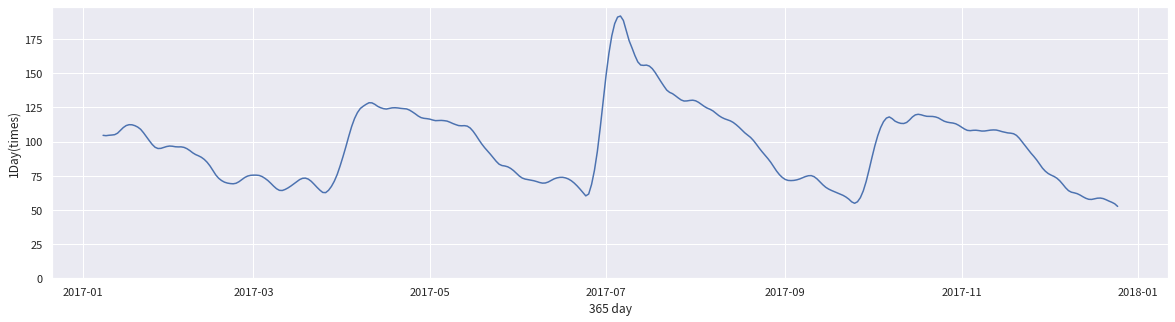

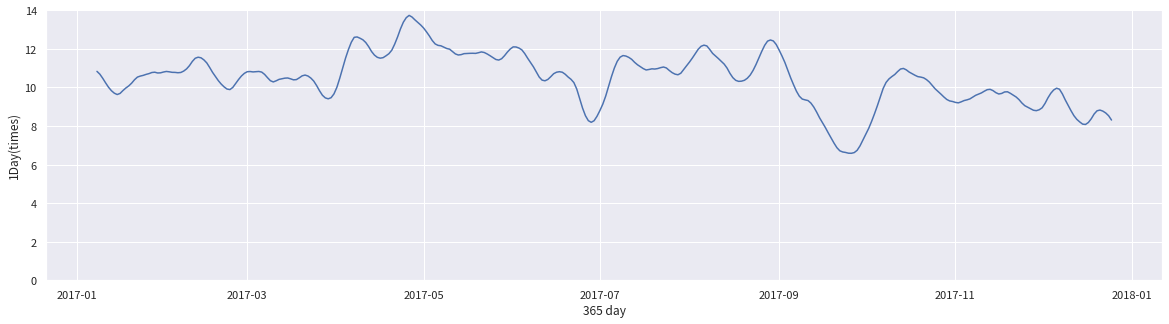

In [28]:
ckday = crcount.groupby(['year', 'month', 'day', 'kind']).sum()
ckday = ckday.pivot_table('num', index=['month', 'day'], columns='kind',aggfunc='mean',fill_value=0)
ckday = ckday.loc[(1, 1):(2, 28)].append(ckday.loc[(3, 1):(12, 31)]) #除去(2/29)資料
ckday.index = [pd.datetime(2017, month, day) for (month, day) in ckday.index]
for n in range(7):
    rolling = ckday.iloc[:,n].rolling(14, center=True, win_type='cosine')
    fig = plt.figure(figsize=(20, 5))
    plt.plot(rolling.mean())
    plt.ylabel('1Day(times)')
    plt.ylim(0,)
    plt.xlabel('365 day')
    print(ckday.columns[n])
    display(fig)